## Import Libraries

In [23]:


import numpy as np # linear algebra
import pandas as pd # data processing

import os,glob
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

img_dir="CGnA10766/data/cgna/*.jpg"
img_list=glob.glob(img_dir)
img_list.remove("CGnA10766/data/cgna/pic.jpg")
img_list=sorted(img_list,key=lambda x:int(x.split('/')[-1].split('.')[0]))

In [24]:


%matplotlib inline

import fastai

from fastai import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback


In [25]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

## Loading the Data

In [26]:
from numpy import genfromtxt
path_a = 'arousal_avg_10766_v2.txt'
path_v = 'valence_avg_10766_v2.txt'
mat_a = genfromtxt(path_a).tolist()
mat_v = genfromtxt(path_v).tolist()
assert len(mat_v)==len(mat_a)==len(img_list)

In [27]:
columns = ['image','arousal','valence']

In [28]:
instances = len(img_list)

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [29]:
df['image']=img_list
df['arousal']=[(i-1)/8 for i in mat_a]
df['valence']=[(i-1)/8 for i in mat_v]

In [30]:
df.head()

,image,arousal,valence
0,CGnA10766/data/cgna/1.jpg,0.23000,0.89000
1,CGnA10766/data/cgna/2.jpg,0.51625,0.41375
2,CGnA10766/data/cgna/3.jpg,0.35000,0.61500
3,CGnA10766/data/cgna/4.jpg,0.54000,0.55875
4,CGnA10766/data/cgna/5.jpg,0.52875,0.49125


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3444d43dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3444d5f198>]], dtype=object)

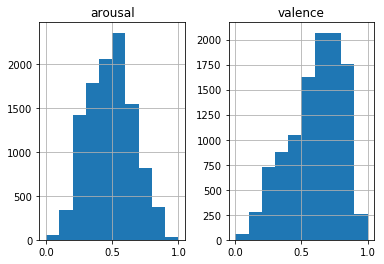

In [31]:
df.hist()

## Preparing the Data for Fastai Models

In [34]:
tfms = get_transforms(max_lighting=None, do_flip=True)

path = Path('/path/to/dataset/')
data_small = ImageList.from_df(df, path, cols=['image'], folder ='.').split_by_rand_pct(0.2, seed=42).label_from_df(label_cls=FloatList,cols=['arousal','valence']).transform(tfms,  size=128).databunch().normalize(imagenet_stats)
data_big = ImageList.from_df(df, path, cols=['image'], folder ='.').split_by_rand_pct(0.2, seed=42).label_from_df(label_cls=FloatList,cols=['arousal','valence']).transform(tfms, size=400).databunch(bs=24).normalize(imagenet_stats)

## A look at the Images

In [35]:
data_small.show_batch(4, figsize=(12,12))

## Fastai Modelling

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random

In [37]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list(models.resnet50(pretrained=True).children())[:-1]
        layers += [Flatten()]
        layers += [nn.Linear(2048,128),nn.ReLU(),nn.Linear(128,2)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        out=self.model(x)
        return out
          # could add 116*torch.sigmoid

In [38]:
model = Model()

In [39]:
learn = Learner(data_big, model, model_dir = "/path/to/models/", bn_wd=False,metrics=root_mean_squared_error,
               callback_fns=[ShowGraph])

In [41]:
import fastai
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion = True)

In [42]:
lr = 4e-6
# lr=learn.recorder.min_grad_lr
wd = lr/5
epoch=100

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.026358,0.024886,0.156751,01:39
1,0.024824,0.022739,0.149983,01:40
2,0.021867,0.022074,0.147696,01:39
3,0.021777,0.021457,0.145656,01:39
4,0.019303,0.021310,0.145096,01:39
5,0.018229,0.021022,0.144079,01:39
6,0.017467,0.021019,0.144047,01:39
7,0.016707,0.020693,0.142939,01:39
8,0.016092,0.020730,0.143110,01:39
9,0.015816,0.020669,0.142869,01:39


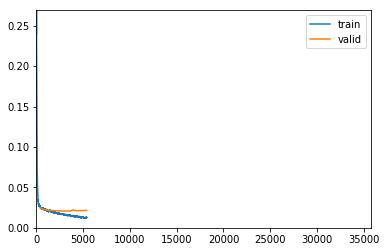

Better model found at epoch 0 with valid_loss value: 0.024886315688490868.
Better model found at epoch 1 with valid_loss value: 0.022739285603165627.
Better model found at epoch 2 with valid_loss value: 0.022073712199926376.
Better model found at epoch 3 with valid_loss value: 0.02145657129585743.
Better model found at epoch 4 with valid_loss value: 0.021309902891516685.
Better model found at epoch 5 with valid_loss value: 0.02102157287299633.
Better model found at epoch 6 with valid_loss value: 0.021018601953983307.
Better model found at epoch 7 with valid_loss value: 0.0206926092505455.
Better model found at epoch 9 with valid_loss value: 0.020669138059020042.
Epoch 14: early stopping


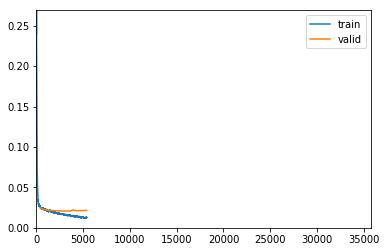

In [43]:
learn.fit(epoch, lr, wd=wd, callbacks=[SaveModelCallback(learn),EarlyStoppingCallback(learn,patience=4)])

In [51]:
learn.save('resnet50_av_CGNA_0.020669')